# Marketing: Directing Customers To Subscription Products Through App Behavior Analysis

### Author: Harry Patterson

                                ====================================================

## Table of Contents

### The Problem
- [Who will subscribe?](#problem)
- [What are we trying to accomplish?](#Objective)

### Data Quality Check
- [Simple Inspection of Data](#Inspection)
- [Clean Data](#datacleaning)

### Exploratory Data Analysis
- [Overview of Data Analysis](#Examine)
- [Visuals of Distributions](#Distributions)
- [View of Correlations](#Corr)
- [Plots in respect to our target feature](#Plots)

### Feature Engineering 
- [Feature Engineering](#fe)
- [Pre-processing](#pp)

### Model Building 
- [Model Selection](#MS)
- [Train_Test Split](#Train_Test)



### Ending Remarks 
- [Final thoughts](#conclusion)

***

<a id='problem'></a>
# The Problem

- Marketing efforts are not free. So, the company needs to know exactly who to target with offers and promotions. 
- Company needs to gain profits by customers paying for upgraded memberships which allows the customers to have more features. 

***

<a id='Objective'></a>
# The Objective

- We want to build a model that will predict which users will or will not subscribe to the paid memberships. 
- Direct marketing efforts to convert customers from free products/services to paid users. 
- To identify the potential features that will directly impact which users, who may or may not subscribe to premimum memberships.
- This business only have 24-hour free trial of the premium features. The company wants to identify the potential customers who are not likely to subscribe shortly after the trial is over.

***

## Understanding the Data
- User: Identifier 
- first_open: User first opens the app (day and time)
- dayofweek: Day of week in numerical form. 0 - Sunday
- hour: hour of the day when user open app
- age: Age of customer
- screen_list: Describes screen name the user have visted in first 24 hours
- numscreens: The number of screens that appear in the screen list field
- minigame: Mini games that the player can play. 0 - User does not play mini game in first 24 hours. ! means the user does play a minigame
- liked - 1 means user likes any particular feature within the app. 0 Does not like any feature
- used_premium_feature: 1 means the user uses any premium feature during the free trial. 0 Does not
- enrolled: 1 means user enrolled in the paid product. 0 does not
- enrolled_date: When the user enrolled in the paid subscribtion (Does not mean within first 24 hours) 

## Import Libraries

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from dateutil import parser

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import time

In [2]:
# Functions to use later

def creating_histplot(size, data, features):    # (size:(height,length))
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(3, 3, i+1)                  # (rows, columns)
        sns.histplot(data[features[i]], kde = True)

## Read The Data

In [3]:
subscriber_df = pd.read_csv('Data/appdata10.csv')
subscriber_df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


<a id='Inspection'></a>
# Data Quality Check
***

In [4]:
subscriber_df.shape

(50000, 12)

In [5]:
subscriber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user                  50000 non-null  int64 
 1   first_open            50000 non-null  object
 2   dayofweek             50000 non-null  int64 
 3   hour                  50000 non-null  object
 4   age                   50000 non-null  int64 
 5   screen_list           50000 non-null  object
 6   numscreens            50000 non-null  int64 
 7   minigame              50000 non-null  int64 
 8   used_premium_feature  50000 non-null  int64 
 9   enrolled              50000 non-null  int64 
 10  enrolled_date         31074 non-null  object
 11  liked                 50000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


In [6]:
# Take a look at the distributions 
subscriber_df.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
subscriber_df.std()

user                    107768.520361
dayofweek                    2.031997
age                         10.803310
numscreens                  15.728812
minigame                     0.310156
used_premium_feature         0.377402
enrolled                     0.485023
liked                        0.371184
dtype: float64

In [8]:
subscriber_df.describe(include='O')

,first_open,hour,screen_list,enrolled_date
count,50000,50000,50000,31074
unique,49747,24,38799,31001
top,2012-11-25 15:00:00.365,15:00:00,Home,2013-02-25 07:47:56.576
freq,7,2989,266,2


In [9]:
subscriber_df.isnull().sum()

user                        0
first_open                  0
dayofweek                   0
hour                        0
age                         0
screen_list                 0
numscreens                  0
minigame                    0
used_premium_feature        0
enrolled                    0
enrolled_date           18926
liked                       0
dtype: int64

In [10]:
print('Number of duplicated records: ', subscriber_df.duplicated().sum())

Number of duplicated records:  15


In [11]:
# Removing duplicates and verify 
subscriber_df = subscriber_df.drop_duplicates()
print('Number of duplicated records in training set: ', subscriber_df.duplicated().sum())

Number of duplicated records in training set:  0


### Results
- Looking at the summary statistics. Nothing about the data looks like it is not supposed to be there. 
- The null values for enrolled_date just means those are the customers that did not enroll at anypoint. 
- It is interesting to see that only 17% of people liked at least one feature. 

***

<a id='datacleaning'></a>
# Clean Data
***

In [12]:
# Change the hour column to the correct data type by slicing

subscriber_df['hour'] = subscriber_df.hour.str.slice(0,3).astype(int)
subscriber_df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


<a id='Examine'></a>
# Examine The Data
***

In [13]:
# Looking at the distribution of the target feature
# Percentage of subscribers or not

subscriber_rate = subscriber_df['enrolled'].value_counts() / subscriber_df.shape[0]
subscriber_rate

1    0.621526
0    0.378474
Name: enrolled, dtype: float64

In [14]:
# check to see is there any real significance for the people that subscribed and who didn't 
# show mean summary

subscriber_summary = subscriber_df.groupby('enrolled')
subscriber_summary.mean()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
enrolled,,,,,,,,
0,186976.558674,3.000264,13.193044,33.541178,16.876361,0.066127,0.197431,0.168411
1,186858.285866,3.047607,12.170309,30.617086,23.666077,0.133196,0.156500,0.163003


### Results 
- With a quick view. We can see on average users are opening the app on a Tuesday. 
- With a quick view. We can see that the average age is lower and the number of screens are higher when it comes to the users who subscribed. 
- We can assume that maybe age, minigame and number of screens play a big role with the users who subscribe. 

***

<a id='Distributions'></a>
# Visuals of Distributions 
***

In [15]:
# Create data for Visualizations 

visual_data = subscriber_df.copy().drop(columns = ['user','screen_list','enrolled_date','first_open','enrolled'])
visual_data.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


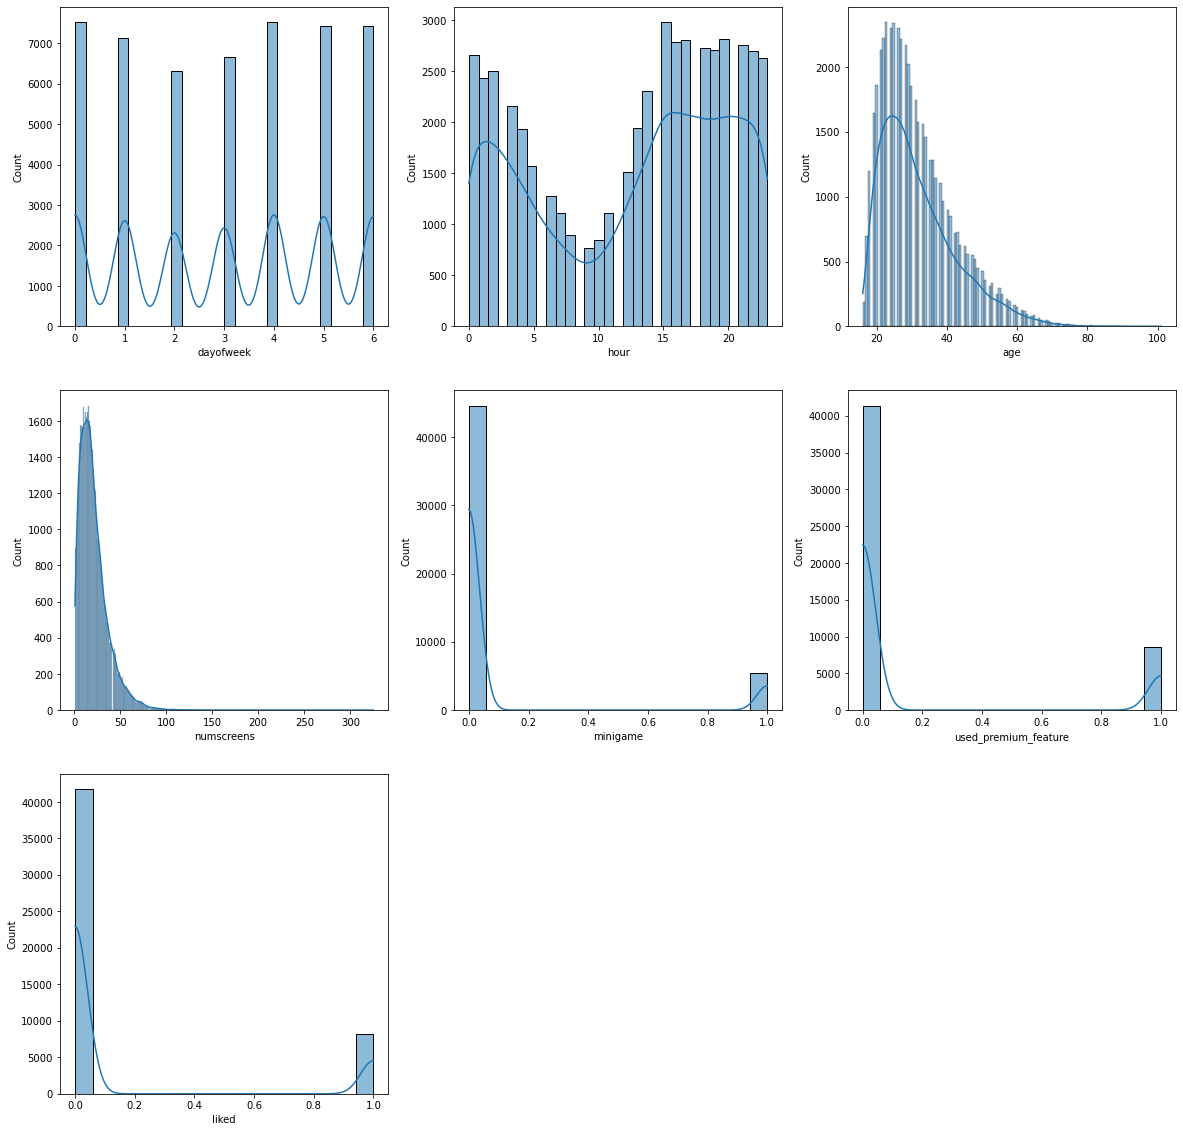

In [16]:
feature = ['dayofweek', 'hour', 'age',
       'numscreens', 'minigame', 'used_premium_feature','liked']


# Creating distribution plots
creating_histplot((20,20), visual_data, feature)     # (width,height)

### Results 

- Day of the week have a even distribution. No particular days have seems to be in favor 
- Can see a big dip in hour (in UTC time) which makes sense because 9 am would be 5am est time then start to creep back up as it gets later. 
- Age has a right tail but seems correct because there would be less people as the age gets older. 

***

<a id='Corr'></a>
# Correlation

- Correlation will show us how each independent variable effects the response variable
- Correlation Matrix will show us any correlation between each individual field and inform us about which fields may be linear dependent on another. 
 
***

<AxesSubplot:title={'center':'Correlation with response variable'}>

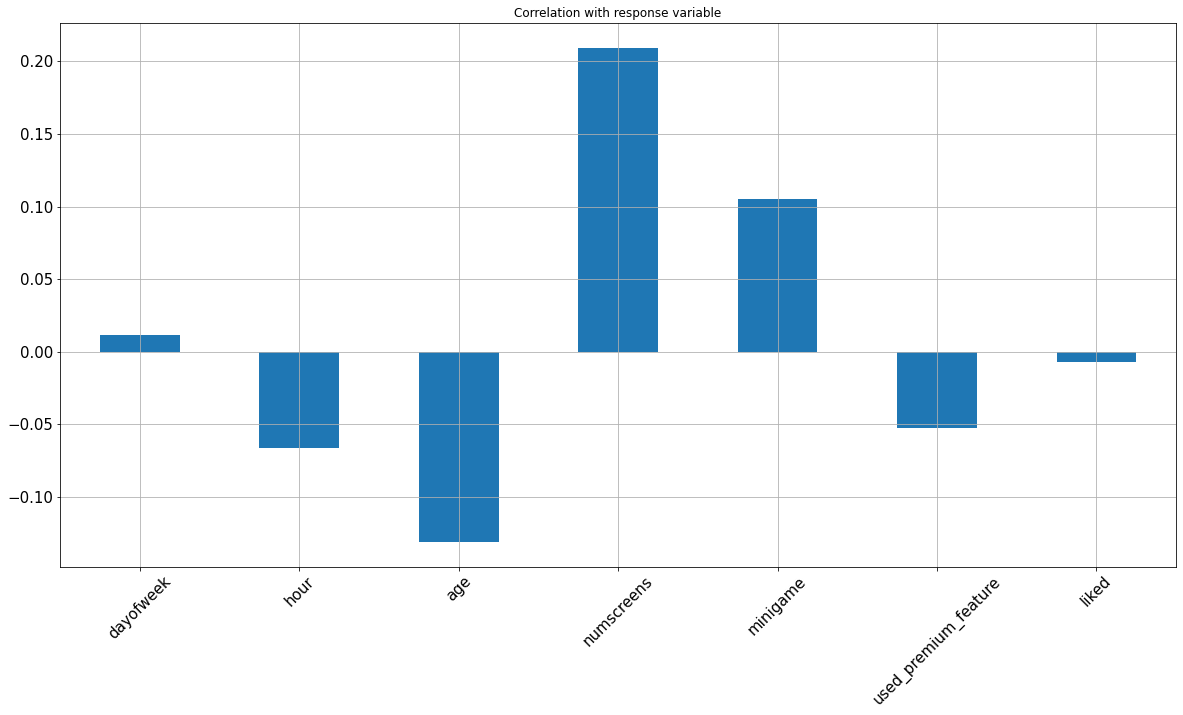

In [17]:
## Correlation with Response Variable

visual_data.corrwith(subscriber_df.enrolled).plot.bar(figsize = (20,10),
                                                     title = 'Correlation with response variable',
                                                     fontsize = 15, rot = 45,
                                                     grid = True)

<AxesSubplot:>

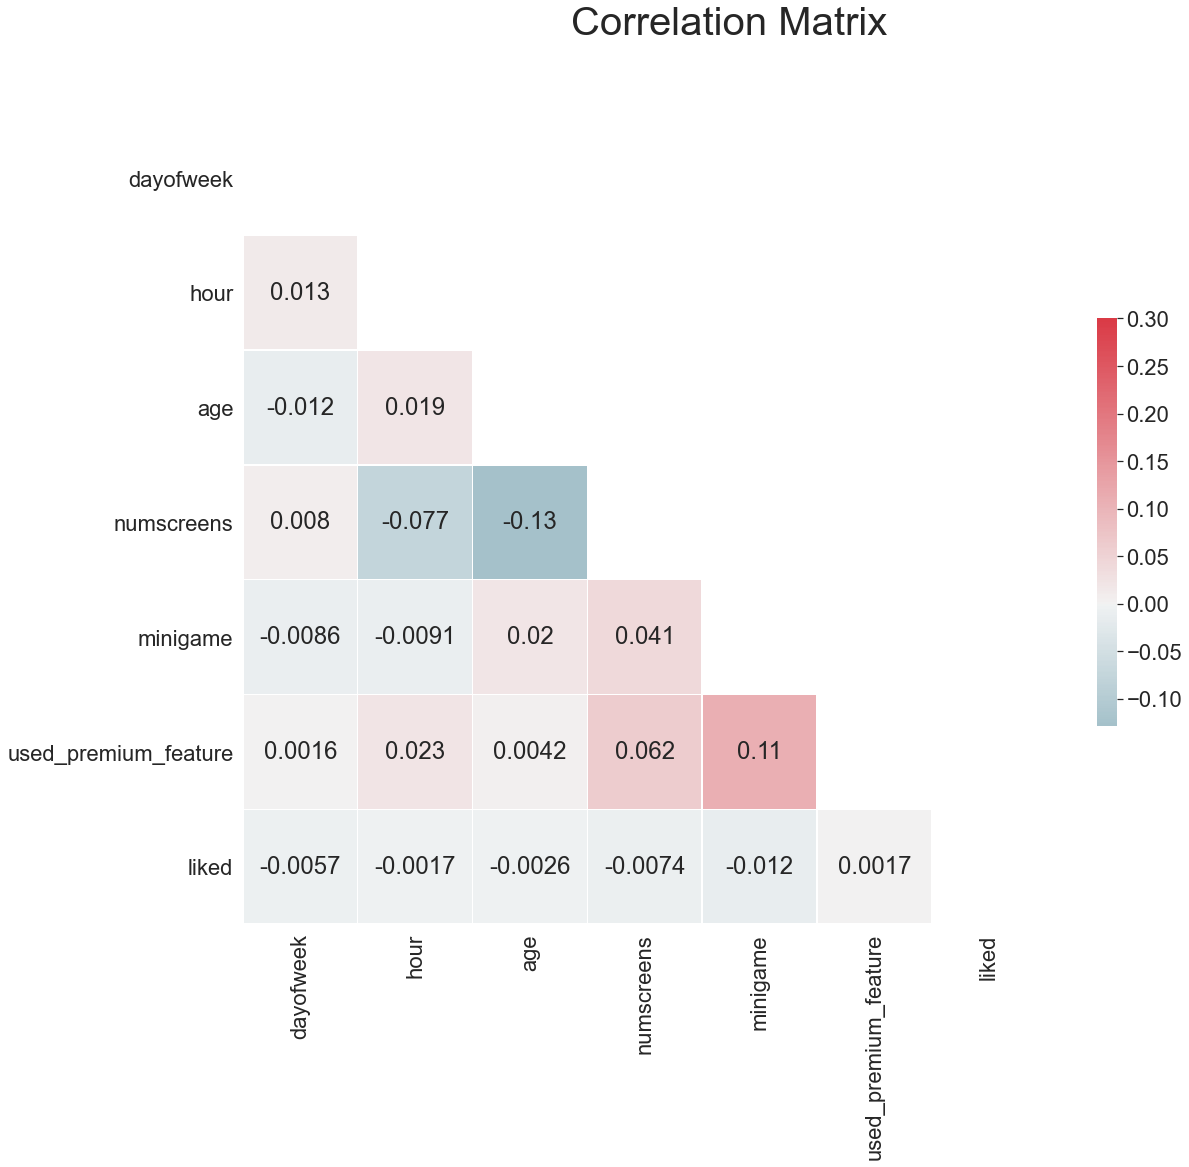

In [18]:
# Build correlation matrix 
sns.set(style="white", font_scale=2)

# Compute the correlation matrix
corr = visual_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))
f.suptitle("Correlation Matrix", fontsize = 40)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Results 


- We can automatically see that none of our explantory fields are highly correlated with eachother due to the highest correlation only being -0.13. 
- Age and number of screens is our most highest negative correlated field which means that as age increases the number of screens will decrease. 
- Use premium feature and minigame is our most highest postive correlation which means if the customer used the premium feature then most likely the customer also played the minigame. 
- We observe there is nothing that indicates linear dependence or any kind of depednce with these fields. So, we can assume that they are all independent variables. 

*** 

<a id='Plots'></a>
#  Distribution/Pair Plots With Respect To Our Target Feature

***

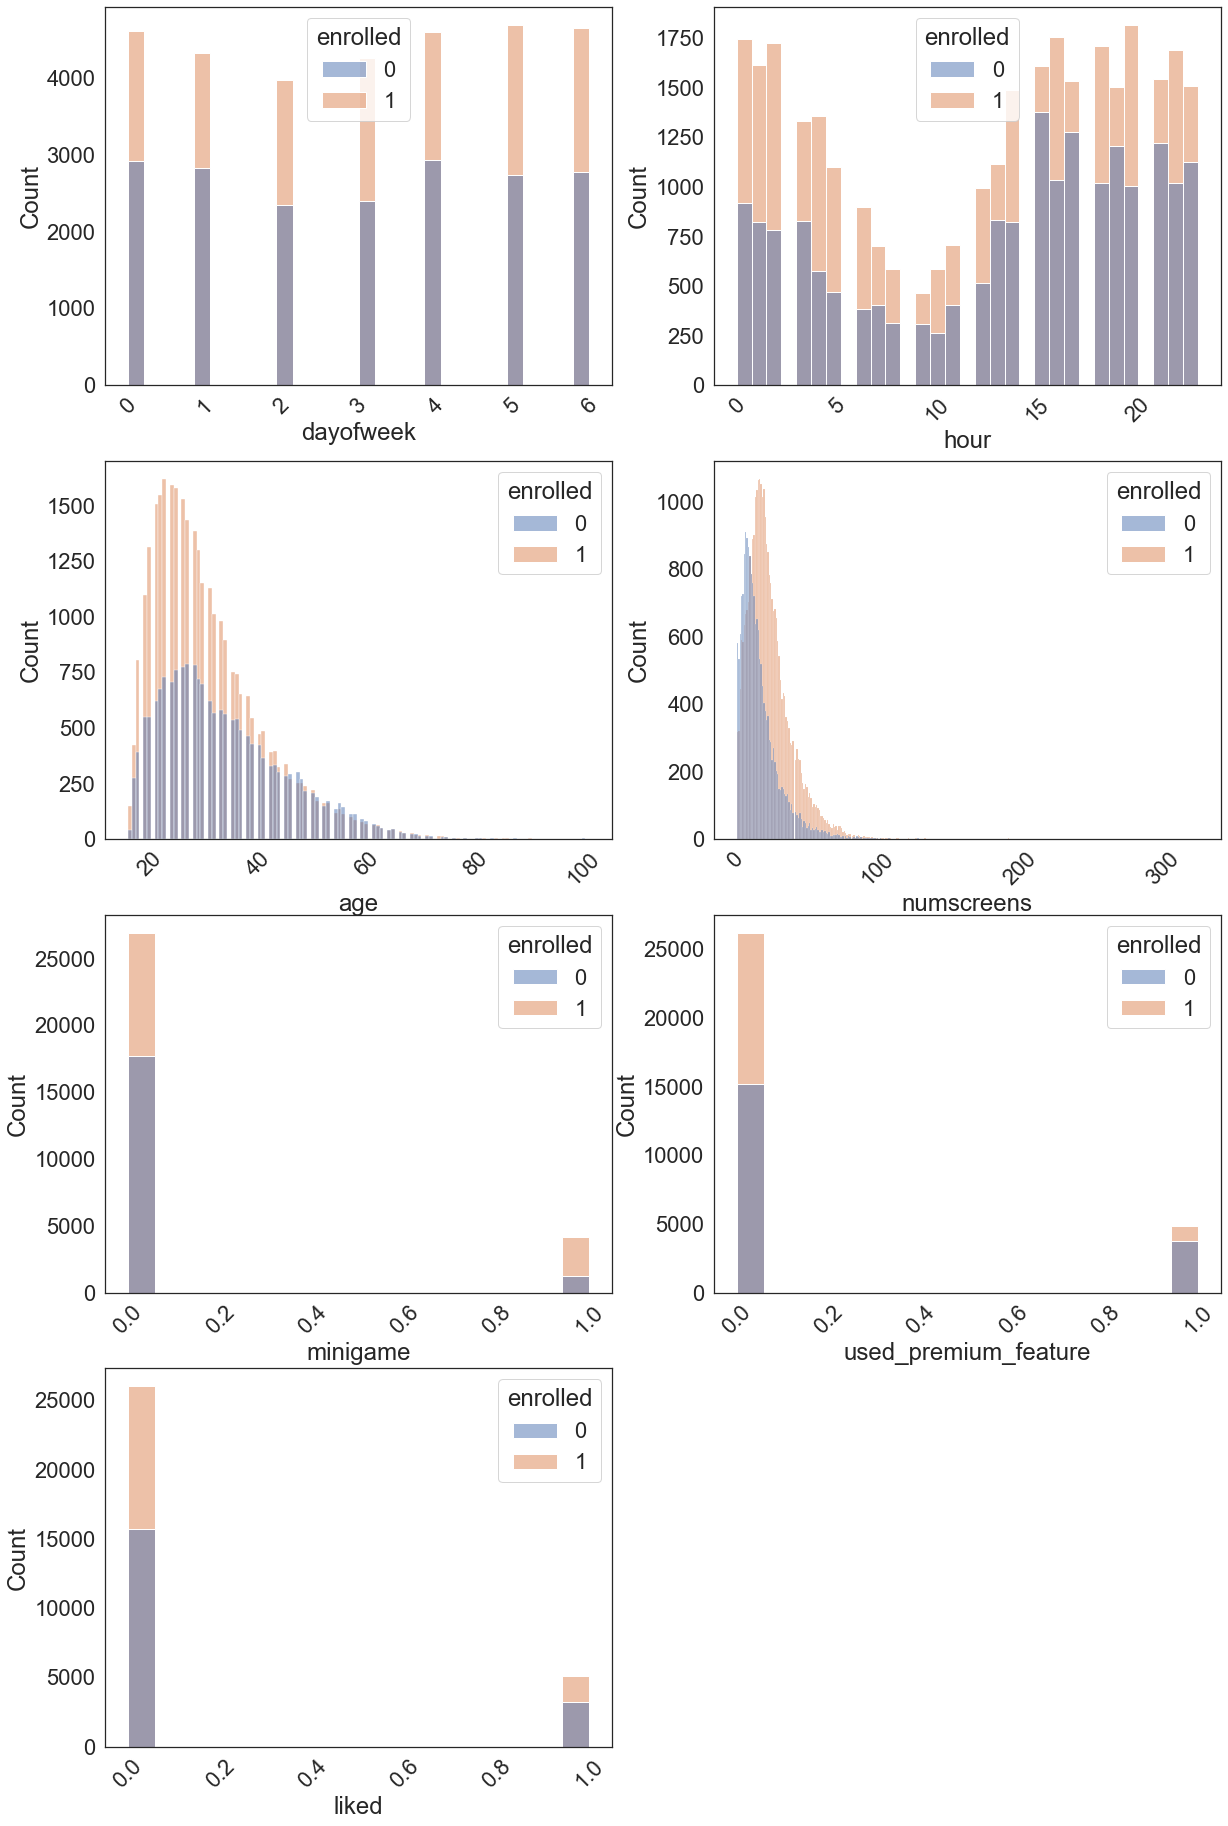

In [19]:
plt.figure(figsize = (20,32))       # width height
for i in enumerate(feature):
    plt.subplot(4,2,i[0] + 1)      # (rows, columns. index number) it can not be 0. so add 1
    sns.histplot(x = i[1], hue = 'enrolled',data = subscriber_df)        # Providing the column name
    plt.xticks(rotation=45)

<Figure size 432x288 with 0 Axes>

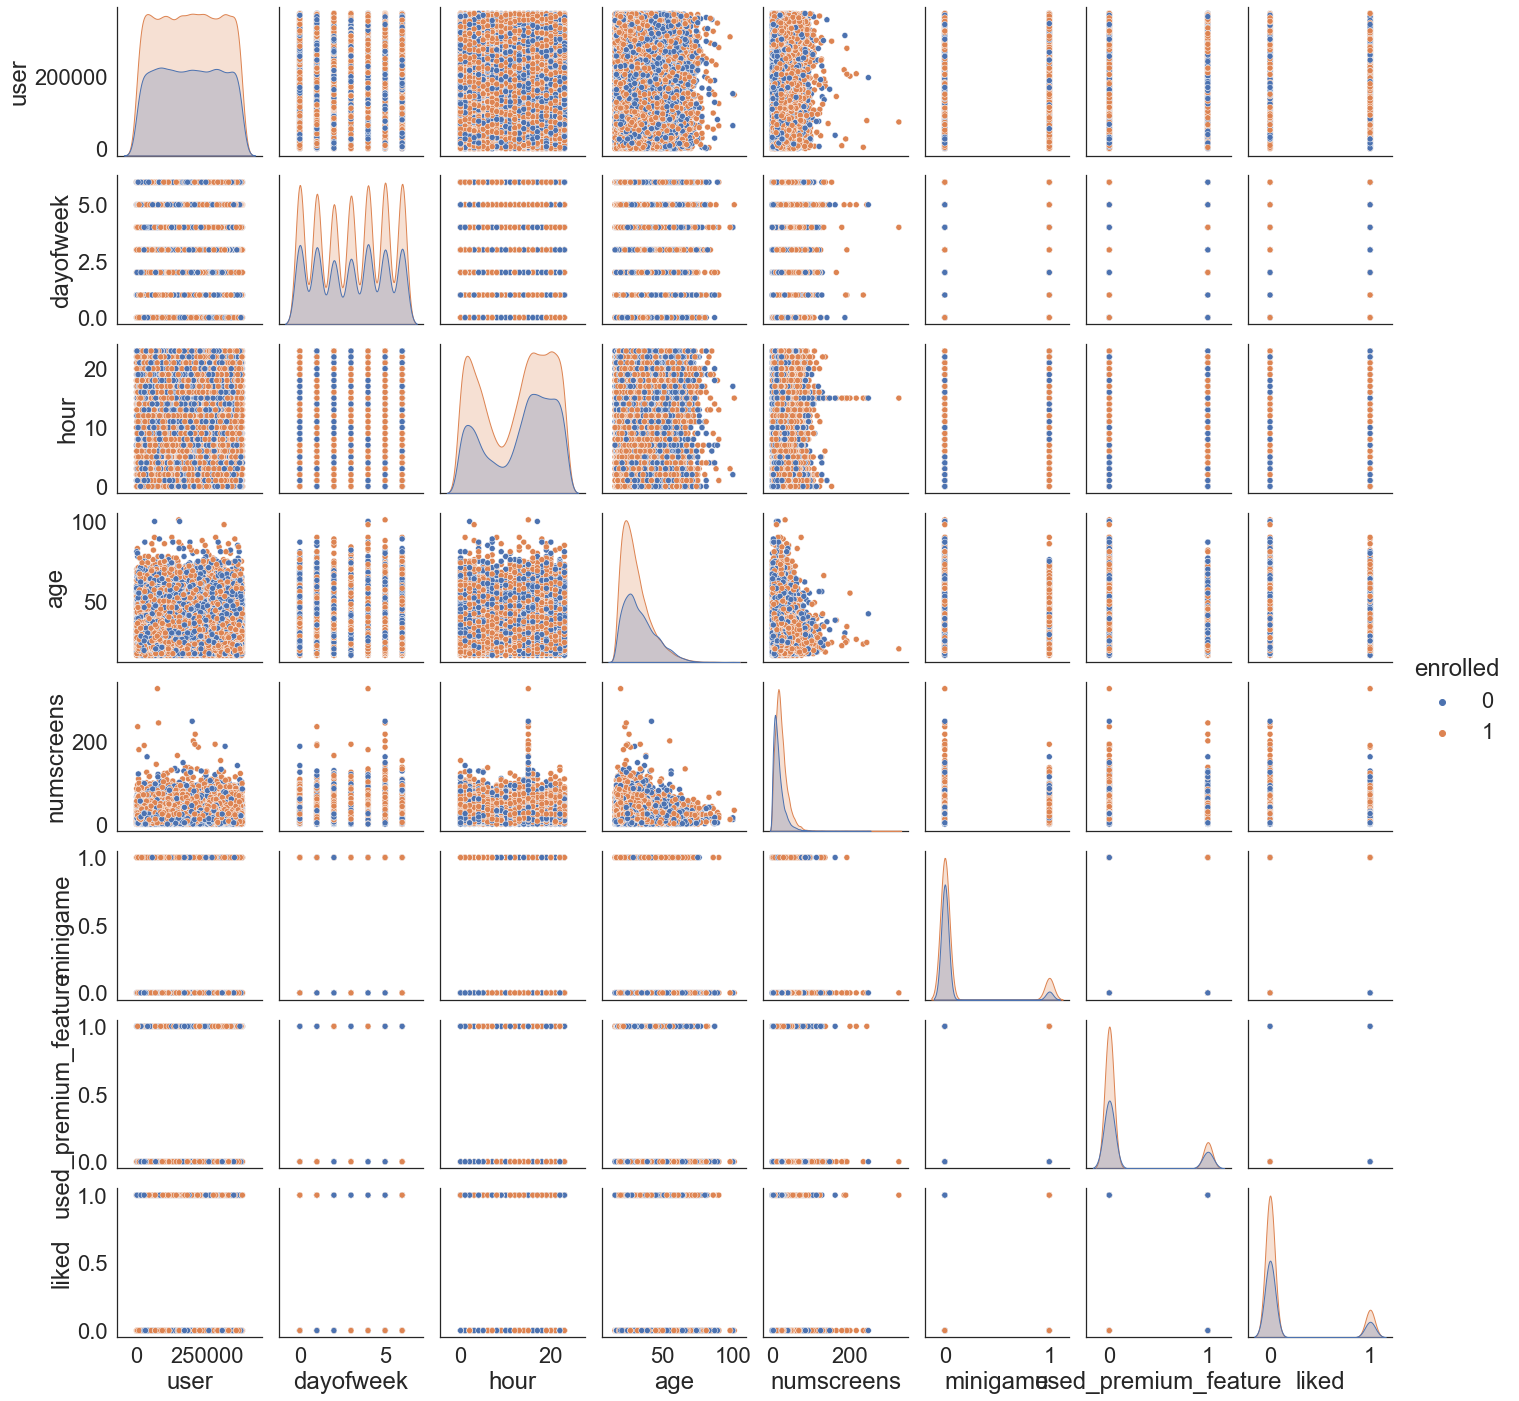

In [20]:
# Pair Plots With Respect To Our Target Feature

num_vars = subscriber_df.select_dtypes(exclude=['object']).columns


plt.figure()
sns.pairplot(data=subscriber_df[num_vars],
             hue="enrolled",
             dropna=True)

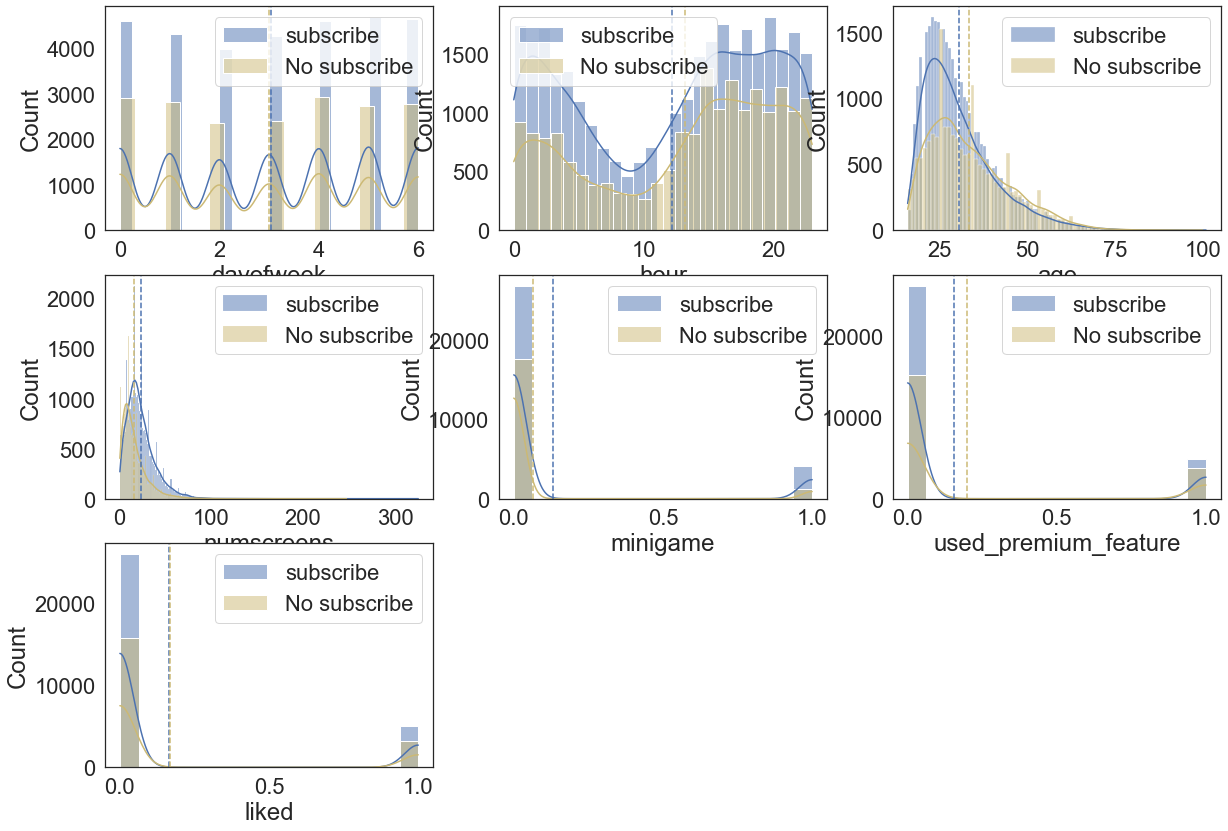

In [22]:
# Just wanted to view a deeper analysis of the target features vs the explantory features. 


# Subsetting by clicks
subcribed_yes = subscriber_df["enrolled"] == 1
subscribed_no = subscriber_df["enrolled"] == 0

# Creating the plots
# features = ["Daily Internet Usage", "Daily Time Spent on Site", "Area Income", "Age"]
labels = ["subscribe", "No subscribe"]

def creating_plots(features, labels):
    plt.figure(figsize=(20,14))
    for feature in features:
        plt.subplot(3, 3, features.index(feature)+1)
        sns.histplot(subscriber_df[feature][subcribed_yes], label=labels[0], color="b",kde=True)
        sns.histplot(subscriber_df[feature][subscribed_no], label=labels[1], color="y",kde=True)
        plt.axvline(subscriber_df[feature][subcribed_yes].mean(), linestyle = '--', color="b")
        plt.axvline(subscriber_df[feature][subscribed_no].mean(), linestyle = '--', color="y")
        plt.legend()

creating_plots(feature, labels)

### Results 

- The numscreens have the highest positive correlation with our target varaible which means as the number of screens increases the more likely to enroll because the uers are more engaged. 
- Age have the highest negative correlation with our target variable which means as the age increases the less likly the user will enroll. 
- It is very interesting to see that used prememium feature have a negative correlation because that would mean the the more likely to use the premium feature the less likely the user will enroll. 
- Day of week and liked seem to have the least amount of significanse when it comes to our target feature. 
- We can tell that there is no clear seperation between our independent features and dependent feature. 

*** 

<a id='fe'></a>
# Feature Engineering 

- Fine tuning the response variable (Date range limit)
- Often we need to set a limit when we expect a user to convert to a paid member. We want to have a way to validate the model in future datasets.
- To understand what time limit is optimal. We will plot the distribution of hour differences between the first open and enrollment date. 
***

In [23]:
subscriber_df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int64
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [24]:
# Convert the dates into date time

subscriber_df['first_open'] = [parser.parse(row_data) for row_data in subscriber_df['first_open']]

In [25]:
 # will check if there is a string value present due to nan being present 

subscriber_df['enrolled_date'] = [parser.parse(row_data) if isinstance(row_data,str) else row_data for row_data in subscriber_df['enrolled_date']] 

In [26]:
# checking work
subscriber_df.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int64
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

In [27]:
# calculate the between enroll date and first open in hours 

subscriber_df['time_difference'] = (subscriber_df.enrolled_date - subscriber_df.first_open).astype('timedelta64[h]')

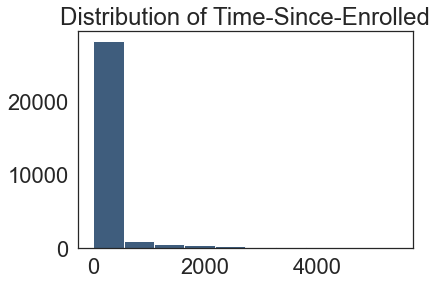

In [28]:
# Plot distributions to see what is the best hour to select for the response variable 

plt.hist(subscriber_df['time_difference'].dropna(), color = '#3F5D7D')
plt.title('Distribution of Time-Since-Enrolled')
plt.show()

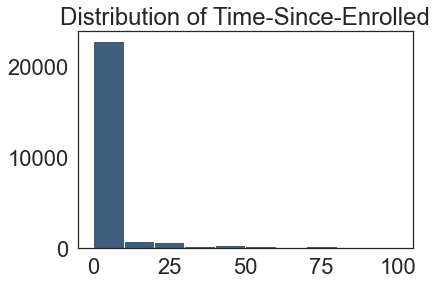

In [29]:
plt.hist(subscriber_df['time_difference'].dropna(), color = '#3F5D7D', range = [0,100])
plt.title('Distribution of Time-Since-Enrolled')
plt.show()

In [30]:
# We will convert any user that did not enroll within the first 48 hours to a 0 (Did not enroll)

subscriber_df.loc[subscriber_df.time_difference > 48, 'enrolled'] = 0 

In [31]:
# Now we remove columns because we do not need them anymore 

subscriber_df = subscriber_df.drop(columns = ['time_difference','enrolled_date', 'first_open'])
subscriber_df.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked
0,235136,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0
1,333588,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0
2,254414,1,19,23,"Splash,Cycle,Loan",3,0,1,0,1
3,234192,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,0
4,51549,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,1


### Taking a look at screenlists 

In [32]:
subscriber_df.screen_list.value_counts()

Home                                                                                                                                                                                                                                                                                                                                                                                                                                                                       266
joinscreen,product_review,product_review2,ScanPreview,VerifyDateOfBirth,location,VerifyCountry,VerifyPhone,VerifyToken,VerifySSN,product_review,SelectInstitution,BankVerification                                                                                                                                                                                                                                                                                         231
joinscreen,product_review,product_review2,ScanPreview,VerifyDateOfBirth,lo

In [33]:
# We have a top screens dataset that tells us the top screens used that people use the most 

top_screens = pd.read_csv('Data/top_screens.csv').top_screens.values
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [34]:
# Mapping Screens to Fields by separating it from the string into their own little list of vectors 
# Create column for these popular screens and for the rest we will create another column for ..... 


subscriber_df['screen_list'] = subscriber_df.screen_list.astype(str) + ','     # Add comma to create as many commas as their are screens. Makes easier  


for sc in top_screens:
    subscriber_df[sc] = subscriber_df.screen_list.str.contains(sc).astype(int)               # Returns a boolean but will convert to int (1 or 0)
    subscriber_df['screen_list'] = subscriber_df.screen_list.str.replace(sc + ',','')        # Remove the screens from the list of screens we was working with

In [35]:
# Work with screens that was not in the list of popular top screens 
# Create another column which indicates how many left over screens we have 
# Count how many commas are left (Tells us the number of screens)

subscriber_df['Other'] = subscriber_df.screen_list.str.count(",")

In [36]:
# Now we will drop screen list because it is no longer needed
subscriber_df = subscriber_df.drop(columns=['screen_list'])

In [37]:
subscriber_df.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,Loan2,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,Other
0,235136,3,2,23,15,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,7
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6
4,51549,1,18,31,32,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,10


In [38]:
subscriber_df.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'Loan2', 'location',
       'Institutions', 'Credit3Container', 'VerifyPhone', 'BankVerification',
       'VerifyDateOfBirth', 'ProfilePage', 'VerifyCountry', 'Cycle',
       'idscreen', 'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash',
       'Loan', 'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts', 'Saving8',
       'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile', 'VerifyHousing',
       'RewardDetail', 'VerifyHousingAmount', 'ProfileMaritalStatus',
       'ProfileChildren ', 'ProfileEducation', 'Saving7',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'Saving2', 'Saving6', 'Saving2Amount', 'Saving5',
       'ProfileJobTitle', 'Login', 'ProfileEmploymentLength', 'WebView',
       'SecurityModal', 'Loan4', 'ResendTok

In [39]:
# Funnels are a group of strings that belong to the same set 
# There are many screens that may correlate to eachother as we see in the columns 
# We will get rid of the correlation but still keep the value of the screens by grouping into funnels


# counts all the columns that have the savings name and sums it all up
# Remove all screens from the columns because they are very corrleated and aggregated them together as the savings count
# 3
savings_screens = ["Saving1", "Saving2", "Saving2Amount", "Saving4", "Saving5", "Saving6", "Saving7", "Saving8", "Saving9", "Saving10"]
subscriber_df["SavingCount"] = subscriber_df[savings_screens].sum(axis=1)
subscriber_df = subscriber_df.drop(columns=savings_screens)

In [40]:
cm_screens = ["Credit1", "Credit2", "Credit3", "Credit3Container", "Credit3Dashboard"]
subscriber_df["CMCount"] = subscriber_df[cm_screens].sum(axis=1)
subscriber_df = subscriber_df.drop(columns=cm_screens)

In [41]:
cc_screens = ["CC1", "CC1Category", "CC3"]
subscriber_df["CCCount"] = subscriber_df[cc_screens].sum(axis=1)
subscriber_df = subscriber_df.drop(columns=cc_screens)

In [42]:
loan_screens = ["Loan", "Loan2", "Loan3", "Loan4"]
subscriber_df["LoansCount"] = subscriber_df[loan_screens].sum(axis=1)
subscriber_df = subscriber_df.drop(columns=loan_screens)

In [43]:
subscriber_df.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


In [44]:
subscriber_df.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
count,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,...,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000
mean,186903.048995,3.029689,12.557387,31.723777,21.096349,0.107812,0.171992,0.497069,0.165050,0.517775,...,0.014224,0.013344,0.013384,0.008202,0.007582,6.214744,0.365050,0.927698,0.176813,0.788357
std,107771.058591,2.032024,7.438224,10.803720,15.728734,0.310146,0.377377,0.499996,0.371229,0.499689,...,0.118415,0.114744,0.114914,0.090196,0.086746,3.672581,1.405614,1.217460,0.612688,0.677427
min,13.000000,0.000000,0.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93528.000000,1.000000,5.000000,24.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,187210.000000,3.000000,14.000000,29.000000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000
75%,280000.000000,5.000000,19.000000,37.000000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000,1.000000
max,373662.000000,6.000000,23.000000,101.000000,325.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,10.000000,5.000000,3.000000,3.000000


In [45]:
subscriber_df.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'location', 'Institutions',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth', 'ProfilePage',
       'VerifyCountry', 'Cycle', 'idscreen', 'Splash', 'RewardsContainer',
       'EditProfile', 'Finances', 'Alerts', 'Leaderboard', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'ResendToken',
       'TransactionList', 'NetworkFailure', 'ListPicker', 'Other',
       'SavingCount', 'CMCount', 'CCCount', 'LoansCount'],
      dtype='object')

In [46]:
# Saving data

subscriber_df.to_csv('subscriber_final.csv', index = False)

### Results 

- We can see that most users enrolled within the first 500 hours and since the distribution was right skewed. We can dial down a little further then we can see everything is down within the first 10 hours. So, we use 48 hours time to our response variable.
- We see that there are too many screen lists available just to create a dummy variables. So, we will 

*** 

<a id='pp'></a>
# Data Pre-Processing 
 
***

In [47]:
subscriber_final = pd.read_csv('Data/subscriber_final.csv')
subscriber_final.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,9,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,7,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,2,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,8,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,12,0,2,0,1


In [48]:
response = subscriber_final['enrolled']
explantory = subscriber_final.drop(columns = 'enrolled')

In [49]:
# split train test split 

X_train, X_test, y_train, y_test = train_test_split(explantory,response,
                                                   test_size=0.2,
                                                   random_state=0)

In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(39988, 49)
(39988,)
(9997, 49)
(9997,)


In [51]:
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

# Keep user column for to match predictions to user later 

train_identifier = X_train['user']
test_identifier = X_train['user']

# drop user because we no longer need it
X_train = X_train.drop(columns = 'user')
X_test = X_test.drop(columns = 'user')

### feature Scaling 

- All numerical features have been normalized. 
- We do not want any particular numerical field to have a greater influence on the model such as it's absoulute value being very large. 

In [55]:
# Converted training set into a scaled scaled training set 

sc_X = StandardScaler()

X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train))               # Create new dataframe because standscaler returns arrays but we need the index and columns to identify for later 
X_test_scaled = pd.DataFrame(sc_X.transform(X_test))                   # Only transform because it is already been fitted to training set 
X_train_scaled.columns = X_train.columns.values                        # make sure they have columns 
X_test_scaled.columns = X_test.columns.values
X_train_scaled.index = X_train.index.values                              # Get indexes from original training and tests 
X_test_scaled.index = X_test.index.values


X_train = X_train_scaled                                             # Convert original training set into new training set 
X_test = X_test_scaled                                               # Convert original test set into new test set

# Model Building 

In [56]:
# Random state = 0: I can duplicate my results and I can present any accuracy I have found to Managment by duplicating any time i want 
# l1 = Turns into a l1 regularization model. Lasso penalizes any particular field that is strongly correlated to the response variable 
# Used because of the response variable being a scene screen and other features beins a scene screen 
# l1 support 'liblinear' and 'saga' L2 handle newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’

lr = LogisticRegression(random_state=0, penalty = 'l1', solver='liblinear')

lr.fit(X_train,y_train)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

In [57]:
y_pred = lr.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [58]:
# Evaluate if predictions are right or not
# Pretty good 

cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.7659297789336801

In [59]:
# To make sure it is no overfit issue 
# Tells us of the predicted positivies how many were actually real positives and how many were not. 

precision_score(y_test, y_pred)

0.7572057646116893

In [60]:
# Tells us of the real positives. How many did we predict to be positive 

recall_score(y_test, y_pred)

0.7704684317718941

In [61]:
# if one is smaller than the other. F1 is good estimate to guarantee the accuracy of our predictions are acturally good

f1_score(y_test, y_pred)

0.7637795275590551

Test Data Accuracy: 0.7659


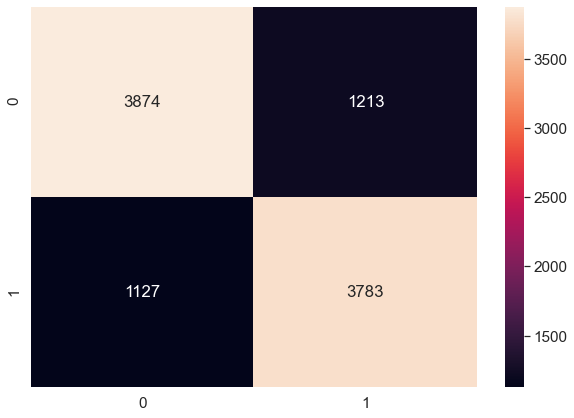

In [62]:
# plot confusion matrix 


df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

# k fold 

- Technique to apply the model to different folds of a training set 
- Makes sure the predicitions are actually good and we did not overfit

*** 

In [63]:
# K-fold giving us an accuracy of 77% with std of .008 (very small)
# Model shows to be consistently accurate 

accuracies = cross_val_score(estimator = lr, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.768 (+/- 0.008)


In [64]:
# Combine to See which users enrolled and not enrolled 

# Formatting the final results


final_results = pd.concat([y_test, test_identity], axis = 1).dropna()       # build data frame with columns 
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [66]:
final_results.head(20)

,user,enrolled,predicted_reach
0,73533,0,0
1,289465,1,0
2,115308,1,0
3,124099,1,1
4,301572,0,0
5,18491,1,0
6,284020,0,0
7,2448,0,0
8,339368,1,1
9,355158,1,1


# Model tuning 

In [69]:
#### Model Tuning ####

## Grid Search (Round 1)

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = lr,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

Took 55.09 seconds


(0.7683054330365984, {'C': 1, 'penalty': 'l1'})

In [72]:
## Grid Search (Round 2)

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = lr,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

lr_best_accuracy = grid_search.best_score_
lr_best_parameters = grid_search.best_params_
lr_best_accuracy, rf_best_parameters
grid_search.best_score_

Took 40.89 seconds


0.7683054330365984

<a id='conclusion'></a>
# Final Remarks 


We can target the users who are not likely to enroll in the paid versions instead of the users who will most likely enroll anyway to help save cost by using these features.


- We notice that the use premium feature is negative correlated which means we can assume that the users that use the premimum feature become uninterested due maybe the user not liking the product or wasn't convinced it was worth paying for. 

- Our efforts have given us a model that will label every new user as "highly likely" or "unlikely to subscribe. 
- We can narrow our marketing efforts only to those users "unlikely" to subscribe, and thus increase our subscription rate. 

- The business can offer the users that are not likely to subscribe an subscribtion offer they can not refuse. 